Revised Incrementality Model

In [204]:
#!pip install pmdarima
# !pip install openpyxl
# !pip install ast
"""
Importing all libraries to execute code
"""
# !pip install pandas
# !pip install statsmodels
# !pip install pmdarima
# !pip install keyring
# !pip install matplotlib
# !pip install numpy
# !pip install scikit-learn
# !pip install openpyxl
# !pip install kagglehub
# !pip install seaborn
from datetime import datetime, timedelta
import pandas as pd
import statsmodels.api as sm
from pmdarima import auto_arima
import keyring

import pandas as pd
import os
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import itertools
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib.dates import date2num
from matplotlib.ticker import FuncFormatter
import time
import ast
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
import openpyxl
import kagglehub
import seaborn as sns


In [205]:
df = pd.read_csv('sales.csv')

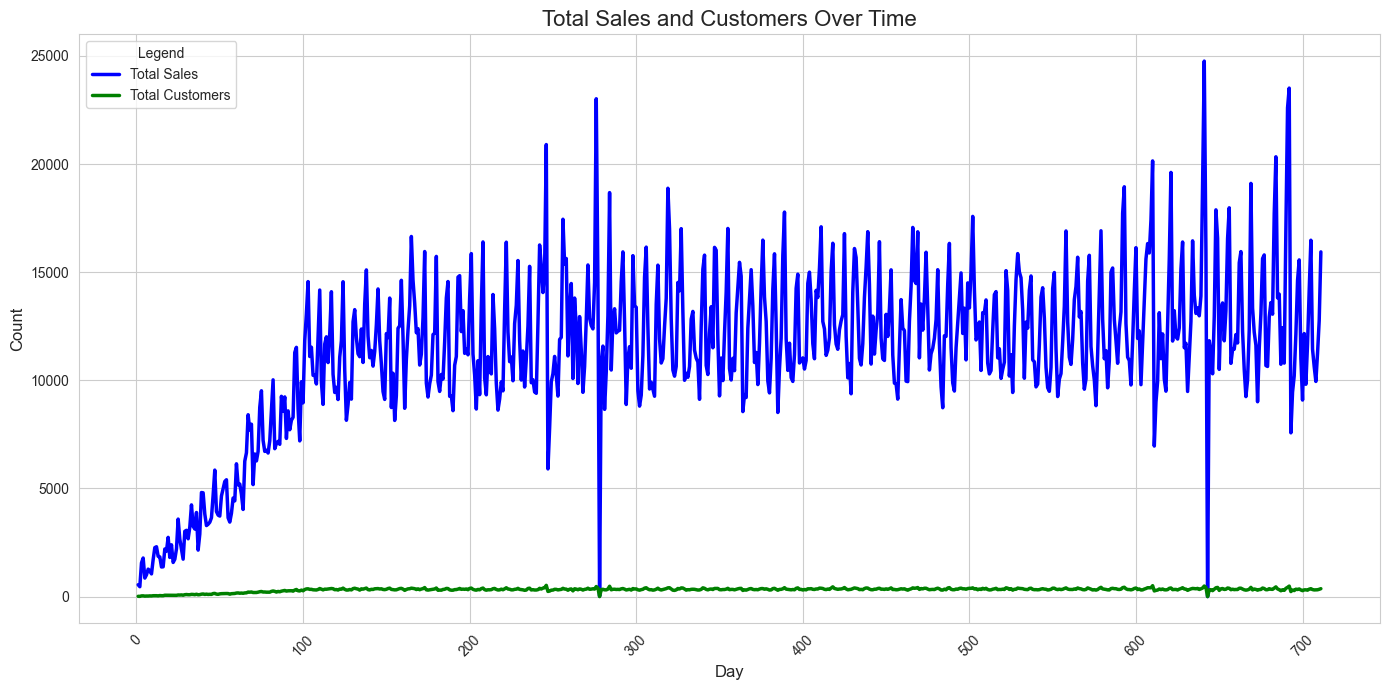

In [206]:
#plot
plt.figure(figsize=(14, 7))

# Set a style for the plot
sns.set_style("whitegrid")

# Plot total sales
sns.lineplot(x='day', y='sales', data=df, label='Total Sales', color='b', linewidth=2.5)

# Plot total customers
sns.lineplot(x='day', y='customers', data=df, label='Total Customers', color='g', linewidth=2.5)

# Add titles and labels
plt.title('Total Sales and Customers Over Time', fontsize=16)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add a legend
plt.legend(title='Legend', fontsize=10)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

start_date = datetime.strptime('23/03/2022', '%d/%m/%Y')
df['date'] = [start_date + timedelta(days=i) for i in range(len(df))]

df.to_clipboard()

2022-03-23 00:00:00
2024-03-02 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
            day          sales  customers
date                                     
2022-03-23    1   549.31000000         15
2022-03-24    2   458.91000000         12
2022-03-25    3  1560.37000000         33
2022-03-26    4  1785.64000000         36
2022-03-27    5   856.93000000         23
...         ...            ...        ...
2024-02-27  707 10632.36000000        310
2024-02-28  708  9949.90000000        315
2024-02-29  709 11245.74000000        317
2024-03-01  710 12758.04000000        339
2024-03-02  711 15938.70000000        367

[711 rows x 3 columns]


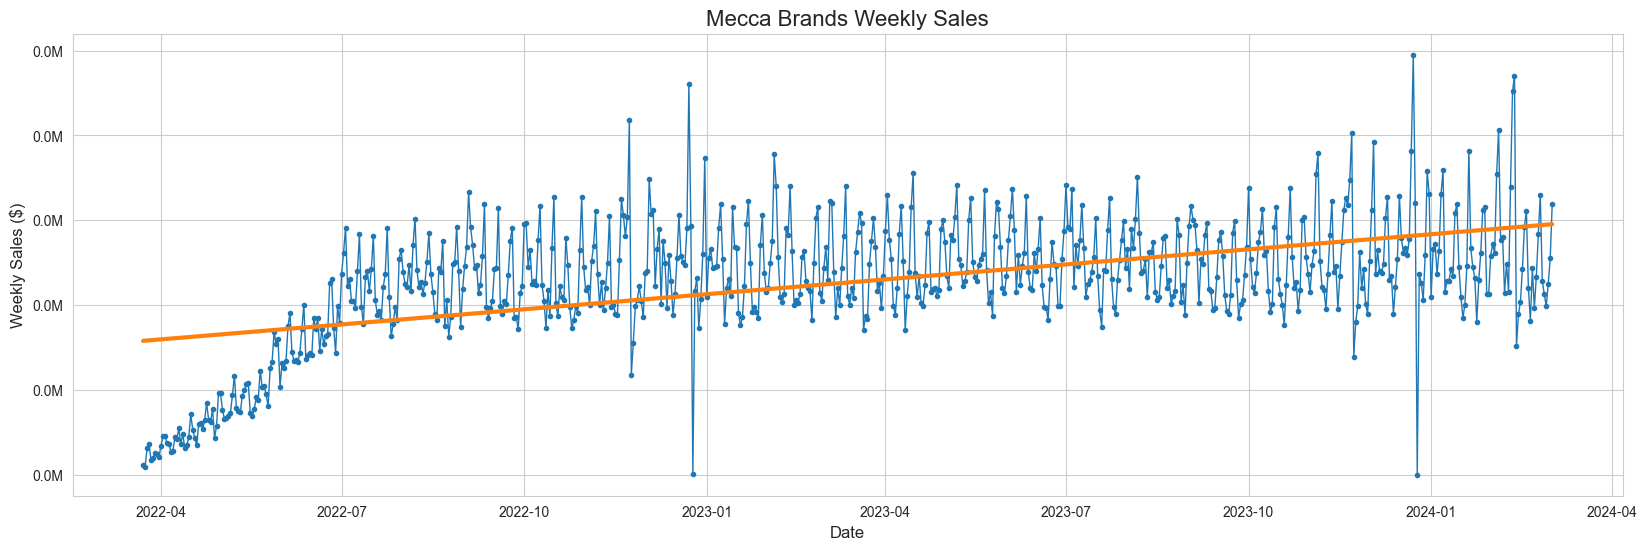

MSE: 9,940,246.86
RMSE: 3,152.82
MAE: 2,463.80
MAPE: 769.49%
R^2: 0.28


In [207]:
# Pulling sales data and calculating the accuracy of linear model.

# df=pd.read_csv('revisedsales2.csv') --remove
data = df

data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
#data['date2'] = pd.to_datetime(data['date'])
#data.to_csv('testing.csv',mode='w+')
data = data.set_index('date')
data.index = pd.DatetimeIndex(data.index, freq='D')
#data = data.iloc[: , 1:]
#data=data[1:] #Removed first week because it is incomplete
data.sort_values(by='date', inplace=True)

# Resample data on a weekly basis and sum the sales
#data = data.resample('D').sum()
# data.to_clipboard()
print( min(data.index))
print( max(data.index))
#data.to_csv('testing')
print(type(data.index[0]))
print(data)
#plot the sales data!
# print(data['date'])
#x=data.index
#data=data['2021-06-01':]
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

y=data['sales']
x = date2num(data.index.to_pydatetime())
x = x.reshape(-1, 1)  # Reshape for sklearn which expects 2D array for features
y = data['sales'].values



#print(highest_points)
reg= LinearRegression().fit(x,y)
y_pred = reg.predict(x)
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(data.index,y,marker='.', linestyle='-', linewidth=1, label='Weekly')
ax.plot(data.index,y_pred, linestyle='-', linewidth=3, label='Weekly')
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.title('Mecca Brands Weekly Sales',fontsize=16)
plt.ylabel('Weekly Sales ($)',fontsize=12)
plt.xlabel('Date',fontsize=12)
plt.show()

y = np.array(y)
mse = mean_squared_error(y, y_pred)

# Calculate RMSE
rmse = mean_squared_error(y, y_pred, squared=False)

# Calculate MAE
mae = mean_absolute_error(y, y_pred)

# Calculate MAPE - Handling division by zero if y contains zeros
mape = np.mean(np.abs((y - y_pred) / y)) * 100 if np.all(y) else float('inf')

# Calculate R^2
r2 = r2_score(y, y_pred)

#Calculate the f1 score

print('MSE: {:,.2f}'.format(mse))
print('RMSE: {:,.2f}'.format(rmse))
print('MAE: {:,.2f}'.format(mae))
print('MAPE: {:.2f}%'.format(mape))  # Percentage values don't typically include commas
print('R^2: {:.2f}'.format(r2))

#print(df.to_string())

In [208]:
campaigns = pd.read_excel('campaigns.xlsx',engine = 'openpyxl')
print(campaigns.head(50))
exog= pd.read_excel('exogwithcampaigns.xlsx',engine='openpyxl')
print(exog.columns)
for i in range(1, 31):
    exog[f'campaign_{i}'] = 0

# Ensure the 'day' column in exog is in the correct format
# Assuming 'day' is an integer or similar that represents the day number

# Iterate over each campaign and hot-encode the corresponding column in exog
for index, row in campaigns.iterrows():
    start_day = row['start_day']  # Assuming 'start_day' is an integer or similar
    end_day = row['end_day']      # Assuming 'end_day' is an integer or similar
    campaign_number = row['campaign']  # Assuming there's a column indicating the campaign number

    # Set the corresponding campaign column to 1 for days within the campaign period
    exog.loc[(exog['day'] >= start_day) & (exog['day'] <= end_day), f'campaign_{campaign_number}'] = 1

# Create a 'campaign' column that is 1 if any campaign_1 to campaign_30 is 1, else 0
exog['campaign'] = exog[[f'campaign_{i}' for i in range(1, 31)]].any(axis=1).astype(int)

print(exog)
exog.to_clipboard()



   description  campaign  start_day  end_day  \
0        TypeA        26        224      264   
1        TypeC        27        237      300   
2        TypeB        28        259      320   
3        TypeB        29        281      334   
4        TypeA        30        323      369   
5        TypeB         1        346      383   
6        TypeB         2        351      383   
7        TypeC         3        356      412   
8        TypeB         4        372      404   
9        TypeB         5        377      411   
10       TypeC         6        393      425   
11       TypeB         7        398      432   
12       TypeA         8        412      460   
13       TypeB         9        435      467   
14       TypeB        10        463      495   
15       TypeB        11        477      523   
16       TypeB        12        477      509   
17       TypeA        13        504      551   
18       TypeC        14        531      596   
19       TypeC        15        547     

In [209]:
exog = exog.set_index('date')
exog.index = pd.DatetimeIndex(exog.index, freq='D')
print(len(exog))
print(type(exog['campaign']))


# Convert your date column to datetime format if it's not already
#df['date'] = pd.to_datetime(df['date'])
print(exog)
# Create a binary indicator for public holidays

#print(exog.to_string())
print(len(exog))
print(len(y))
#exog.loc[exog.index < '2023-01-01', 'weekend'] = 0

711
<class 'pandas.core.series.Series'>
            day  public_holiday  campaign  campaign_1  campaign_2  campaign_3  \
date                                                                            
2022-03-23    1               0         0           0           0           0   
2022-03-24    2               0         0           0           0           0   
2022-03-25    3               0         0           0           0           0   
2022-03-26    4               0         0           0           0           0   
2022-03-27    5               0         0           0           0           0   
...         ...             ...       ...         ...         ...         ...   
2024-02-27  707               0         1           0           0           0   
2024-02-28  708               0         1           0           0           0   
2024-02-29  709               0         1           0           0           0   
2024-03-01  710               0         1           0           0    

In [210]:
# Remove

# exog = pd.read_excel('exogwithdayofweekandcampaigns.xlsx',engine='openpyxl')
# exog=exog[['date','campaign','weekend']]
# exog['campaign']=exog['campaign'].fillna(0)
# exog = exog.set_index('date')
# exog.index = pd.DatetimeIndex(exog.index, freq='D')
# print(len(exog))
# print(type(exog['campaign']))

# public_holidays = ['2022-12-25','2023-12-25']  

# # Convert your date column to datetime format if it's not already
# #df['date'] = pd.to_datetime(df['date'])
# print(exog)
# # Create a binary indicator for public holidays
# exog['is_public_holiday'] = exog.index.isin(public_holidays).astype(int)
# #print(exog.to_string())
# print(len(exog))
# print(len(y))
# #exog.loc[exog.index < '2023-01-01', 'weekend'] = 0


In [211]:
#adding in fourier terms to the model.
# seasonality=365
# n=1224
# t=1
# # Create Fourier terms for weekly seasonality
# def create_fourier_terms(t, period, num_terms):
#     terms = []
#     for i in range(1, num_terms + 1):
#         terms.append(np.sin(2 * np.pi * i * t / period))
#         terms.append(np.cos(2 * np.pi * i * t / period))
#     return np.column_stack(terms)

# num_fourier_terms = 4
# fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

def fourier_terms(data, period, K):
    # `data` is the DataFrame, `period` is the seasonal period (e.g., 365 for yearly),
    # and `K` is the number of sine/cosine term pairs
    T = len(data)
    t = np.arange(1, T + 1)
    
    fourier_terms = pd.DataFrame(index=data.index)
    
    for k in range(1, K + 1):
        fourier_terms[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        fourier_terms[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
        
    return fourier_terms
K = 6  # Number of terms; adjust based on your model's needs
period = 365  # Yearly seasonality
fourier_terms_df = fourier_terms(data, period, K)
print(fourier_terms_df)
combined_exog = pd.concat([exog, fourier_terms_df], axis=1)
print(combined_exog)
exog=combined_exog

                 sin_1      cos_1       sin_2      cos_2       sin_3  \
date                                                                   
2022-03-23  0.01721336 0.99985184  0.03442161 0.99940740  0.05161967   
2022-03-24  0.03442161 0.99940740  0.06880243 0.99763031  0.10310170   
2022-03-25  0.05161967 0.99866682  0.10310170 0.99467082  0.15430882   
2022-03-26  0.06880243 0.99763031  0.13727877 0.99053245  0.20510450   
2022-03-27  0.08596480 0.99629817  0.17129314 0.98522011  0.25535330   
...                ...        ...         ...        ...         ...   
2024-02-27 -0.38566341 0.92263955 -0.71165662 0.70252747 -0.92754168   
2024-02-28 -0.36972454 0.92914141 -0.68705277 0.72660752 -0.90701381   
2024-02-29 -0.35367612 0.93536795 -0.66163462 0.74982640 -0.88406751   
2024-03-01 -0.33752290 0.94131732 -0.63543230 0.77215658 -0.85876396   
2024-03-02 -0.32126966 0.94698775 -0.60847687 0.79357161 -0.83117063   

                cos_3       sin_4       cos_4       sin_5      

# Mecca Sales Data: Fitting a Linear Regression Model





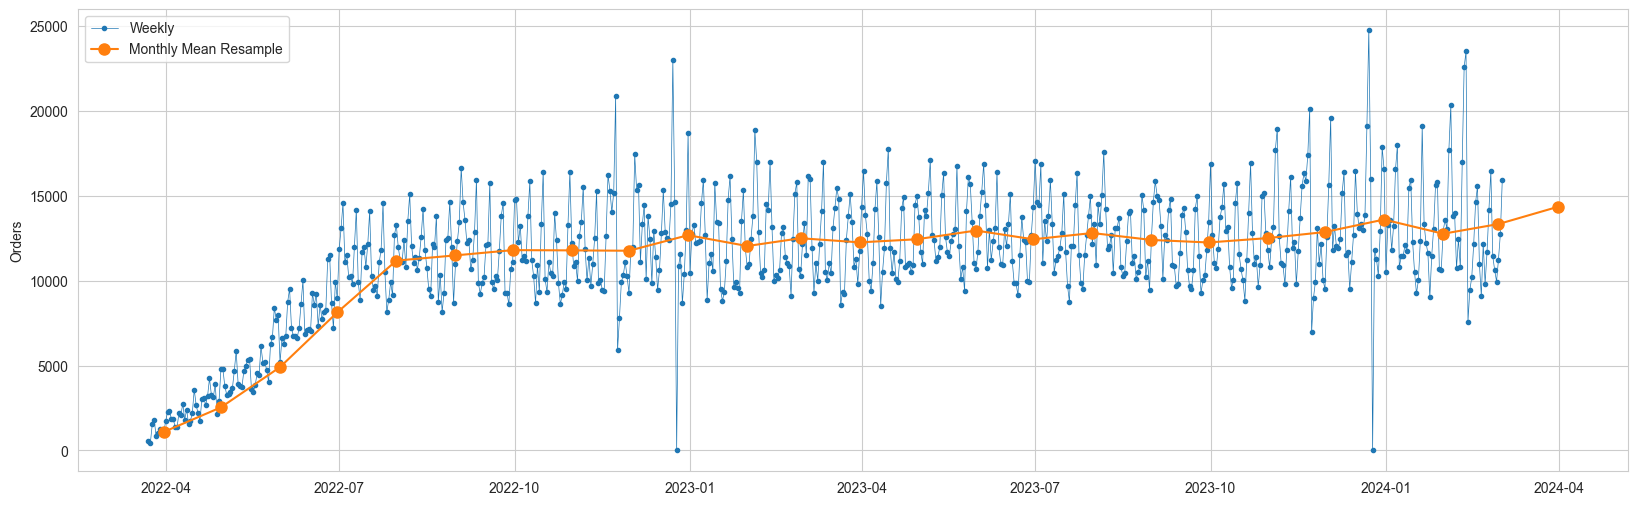

In [212]:
y = data['sales']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend()

In [213]:
# def seasonal_decompose (y):
#     decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq',period=365)
#     seasonal = decomposition.seasonal
#     seasonal_df = pd.DataFrame(seasonal)
#     fig = decomposition.plot()
#     fig.set_size_inches(14,7)
#     plt.show()
#     return seasonal_df
# seasonal_df = seasonal_decompose(y)
# print(seasonal_df)
# seasonal_df.to_csv('MeccaSeasonalIndices.csv')
# # def seasonal_decompose_to_df(y):
# #     decomposition = sm.tsa.seasonal_decompose(y, model='additive', extrapolate_trend='freq', period=365)
# #     # Decompose the time series
# #     seasonal = decomposition.seasonal
# #     # Convert the seasonal component to a DataFrame
# #     seasonal_df = pd.DataFrame(seasonal)
# #     # Plot the decomposition
# #     fig = decomposition.plot()
# #     fig.set_size_inches(14, 7)
# #     plt.show()
# #     # Return the DataFrame
# #     return seasonal_df

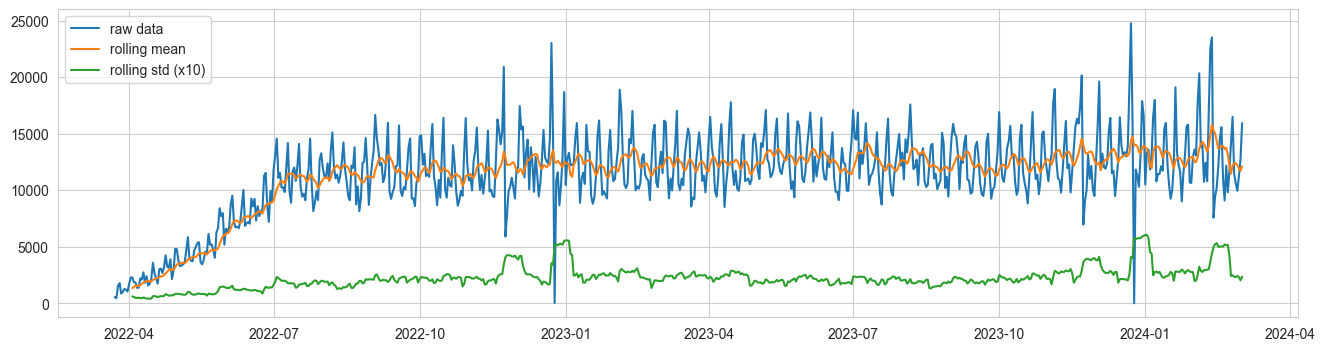

In [214]:
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [215]:
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -4.317
P-value = 0.000
Critical values :
	1%: -3.4398627454742488 - The data is  stationary with 99% confidence
	5%: -2.8657378555534248 - The data is  stationary with 95% confidence
	10%: -2.569005465238395 - The data is  stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -5.605
P-value = 0.000
Critical values :
	1%: -3.4400174432106305 - The data is  stationary with 99% confidence
	5%: -2.8658060125001295 - The data is  stationary with 95% confidence
	10%: -2.569041777564251 - The data is  stationary with 90% confidence


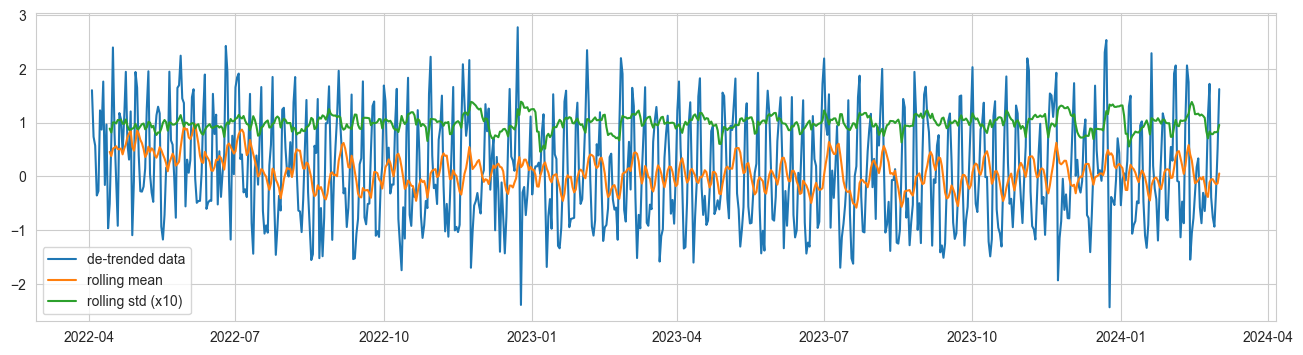

In [216]:
# Detrending
y_float = y.apply(float)

y_detrend = (y_float - y_float.rolling(window=12).mean()) / y_float.rolling(window=12).std()

test_stationarity(y_detrend, 'de-trended data')
ADF_test(y_detrend, 'de-trended data')

 > Is the 12 lag differenced data stationary ?
Test statistic = -7.256
P-value = 0.000
Critical values :
	1%: -3.4400031721739515 - The data is  stationary with 99% confidence
	5%: -2.865799725091594 - The data is  stationary with 95% confidence
	10%: -2.569038427768166 - The data is  stationary with 90% confidence


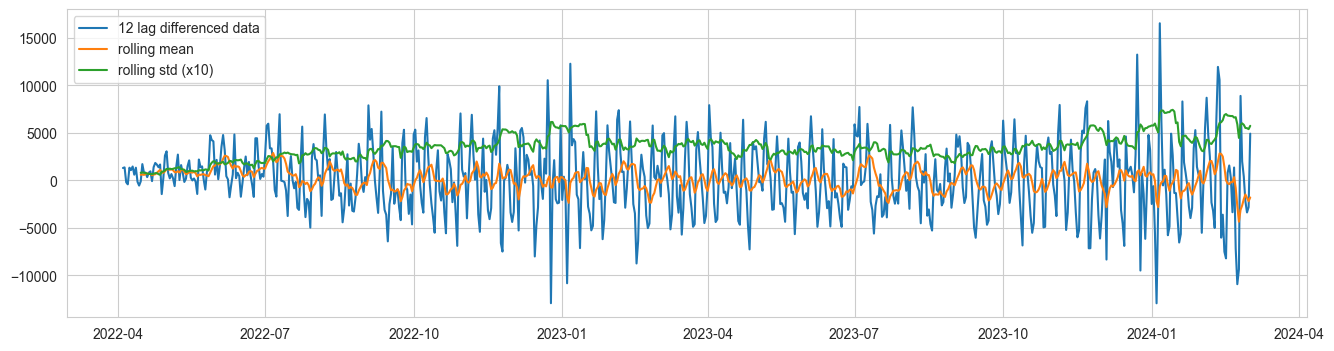

In [217]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -9.893
P-value = 0.000
Critical values :
	1%: -3.4401920464204667 - The data is  stationary with 99% confidence
	5%: -2.865882935271461 - The data is  stationary with 95% confidence
	10%: -2.569082760711099 - The data is  stationary with 90% confidence


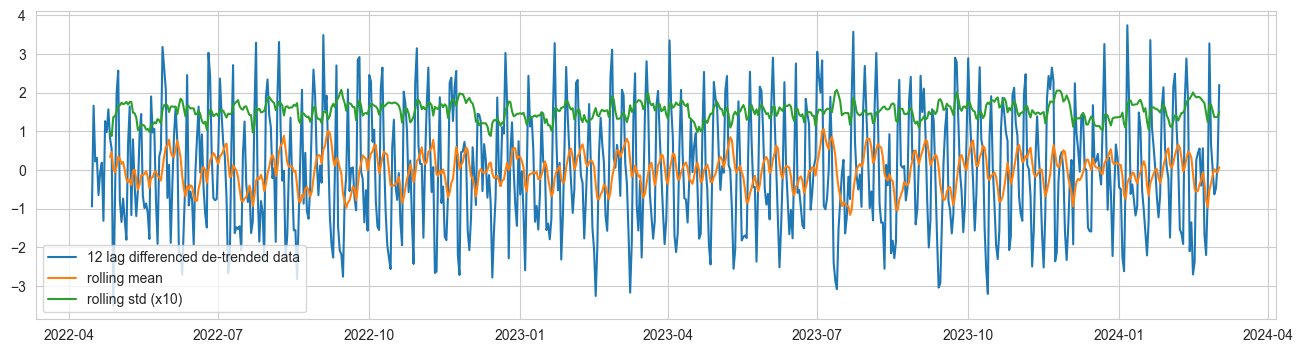

In [218]:
y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

In [219]:

y_to_train = y[:'2022-03-23'] # dataset to train
y_to_val = y['2023-09-23':] # last X months for test  
predict_date = len(y) - len(y[:'2023-01-01']) # the number of data point
#y_float = y.astype(float)
#print(exog)
#exog=exog['campaign']
#exog=exog['2020-09-28':]
#exog=exog['2021-06-01':]
exog_to_train=exog[:'2022-03-23']
exog_to_val=exog['2023-09-23':]

# print(len(y_to_val))
# print(exog_to_val)
# print(type(y_to_val))
# print(y.index.equals(exog.index))

print(len(exog))
print(len(y))
print(max(y.index))
print(min(y.index))
print(max(exog.index))
print(min(exog.index))
exog.to_csv('exogcleaned.csv')
exog.fillna(0, inplace=True)  # Fill with zero

711
711
2024-03-02 00:00:00
2022-03-23 00:00:00
2024-03-02 00:00:00
2022-03-23 00:00:00


In [220]:
# #This is the old grid search
# def sarima_grid_search(y, seasonal_period):
#     # Define the range for p, d, q
#     p = d = q = range(0, 2)  # Keep these ranges small
#     pdq = list(itertools.product(p, d, q))
#     seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]
#     print(pdq)
#     print(seasonal_pdq)
#     wb = load_workbook('seasonalparams.xlsx')
#     sheet = wb.active
#     mini = float('+inf')
#     print(mini)
#     param_mini, param_seasonal_mini = None, None  # Initialize these variables
#     iteration = 0
#     row=1
#     #for param in pdq:
#     for x in range(64):
#         print(x)
#         #for param_seasonal in seasonal_pdq:
#         row+=1
#         iteration += 1  # Increment iteration counter
#         start_time = time.time()  # Start timing this iteration
#         try:
#             param=ast.literal_eval(sheet.cell(row=row, column=1).value)
#             param_seasonal=ast.literal_eval(sheet.cell(row=row, column=2).value)
# #             print(type(param))
# #             print(param)
# #             print(type(param_seasonal))
# #             print(param)
#             #sheet.cell(row=row, column=2).value = str(param_seasonal)
            

#               #  Save the workbook to apply the changes
                
#             mod = sm.tsa.statespace.SARIMAX(y,
#                                                 order=param,
#                                                 seasonal_order=param_seasonal,
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False)

#             results = mod.fit()
#             sheet.cell(row=row, column=3).value=results.aic
#             if results.aic < mini:
#                 mini = results.aic
#                 param_mini = param
#                 param_seasonal_mini = param_seasonal

#         except Exception as e:
#             print(f"An error occurred: {e}")  # To understand what errors are occurring
#             continue
#         finally:
#             end_time = time.time()  # End timing this iteration
#             duration = end_time - start_time  # Calculate duration
#             sheet.cell(row=row, column=4).value=duration
#             print(f'Iteration {iteration}: SARIMA{param}x{param_seasonal} took {duration:.2f} seconds')
#             wb.save('seasonalparams.xlsx')
    
    

#     if param_mini is not None and param_seasonal_mini is not None:
#         print(f'The set of parameters with the minimum AIC is: SARIMA{param_mini}x{param_seasonal_mini} - AIC:{mini}')
#         #print("hi")
#     else:
#         print("No suitable model found")
    
# sarima_grid_search(y,365)


In [230]:
#New gridsearch
def sarima_grid_search(y, seasonal_period):
    p = d = q = range(0, 2)  # Define the range for p, d, q
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]
    
    wb = load_workbook('seasonalparams.xlsx')
    sheet = wb.active

    # Find the last row in column 4 that is populated
    last_row = 1
    for row in range(sheet.max_row, 0, -1):
        if sheet.cell(row=row, column=4).value is not None:
            last_row = row + 1
            break
    print(last_row)
    mini = float('+inf')
    param_mini, param_seasonal_mini = None, None
    iteration = 0

    # Start the loop from the last populated row in column 4
    for row in range(last_row, last_row + 64):  # Adjust 64 based on your requirement
        iteration += 1
        start_time = time.time()
        try:
            param = ast.literal_eval(sheet.cell(row=row, column=1).value)
            param_seasonal = ast.literal_eval(sheet.cell(row=row, column=2).value)

            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

           # Example of handling results
            results_aic = results.aic
            sheet.cell(row=row, column=3).value = results_aic
            if results_aic < mini:
                mini = results_aic
                param_mini = param
                param_seasonal_mini = param_seasonal

        except Exception as e:
            print(f"An error occurred: {e}")
            continue
        finally:
            end_time = time.time()
            duration = end_time - start_time
            sheet.cell(row=row, column=4).value = duration
            #print(f'Iteration {iteration}: SARIMA{param}x{param_seasonal} took {duration:.2f} seconds')
            #print(f'param: {param}     SParam: {param_seasonal}     AIC: {sheet.cell(row=row, column=3).value}     Time: { sheet.cell(row=row, column=4).value}' )
            wb.save('seasonalparams.xlsx')

    #wb.save('seasonalparams.xlsx')

    if param_mini is not None and param_seasonal_mini is not None:
        print(f'The set of parameters with the minimum AIC is: SARIMA{param_mini}x{param_seasonal_mini} - AIC:{mini}')
    else:
        print("No suitable model found")

# Remember to define 'y' and ensure you have the correct imports and setup for SARIMAX fitting
sarima_grid_search(y, 365)

65
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: None
An error occurred: malformed node or string: No

In [231]:


# New gridsearch
def sarima_grid_search(y, seasonal_period):
    p = d = q = range(0, 2)  # Define the range for p, d, q
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]
    
    results_list = []  # List to store results
    mini = float('inf')
    param_mini, param_seasonal_mini = None, None
    iteration = 0

    # Iterate over all combinations of pdq and seasonal_pdq
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            iteration += 1
            start_time = time.time()
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()

                # Example of handling results
                results_aic = results.aic
                results_list.append((param, param_seasonal, results_aic))
                
                if results_aic < mini:
                    mini = results_aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

            except Exception as e:
                print(f"An error occurred: {e}")
                continue
            finally:
                end_time = time.time()
                duration = end_time - start_time
                print(f'Iteration {iteration}: SARIMA{param}x{param_seasonal} took {duration:.2f} seconds, AIC: {results_aic}')

    if param_mini is not None and param_seasonal_mini is not None:
        print(f'The set of parameters with the minimum AIC is: SARIMA{param_mini}x{param_seasonal_mini} - AIC:{mini}')
    else:
        print("No suitable model found")

    # Optionally, print or save the results_list
    for result in results_list:
        print(f'Order: {result[0]}, Seasonal Order: {result[1]}, AIC: {result[2]}')

# Remember to define 'y' and ensure you have the correct imports and setup for SARIMAX fitting
sarima_grid_search(y, 365)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07912D+01    |proj g|=  1.17417D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.174D-07   1.079D+01
  F =   10.791235539505298     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Iteration 1: SARIMA(0, 0, 0)x(0, 0, 0, 365) took 0.04 seconds, AIC: 15347.136937176532


 This problem is unconstrained.
/Users/dharmickmehta/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40578D+00    |proj g|=  4.21889D+00


 This problem is unconstrained.



At iterate    5    f=  4.83544D+00    |proj g|=  1.48181D-04

At iterate   10    f=  4.83543D+00    |proj g|=  7.80629D-03

At iterate   15    f=  4.83409D+00    |proj g|=  8.79191D-02

At iterate   20    f=  4.80907D+00    |proj g|=  6.32048D-02

At iterate   25    f=  4.80811D+00    |proj g|=  2.93330D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     28      1     0     0   2.933D-06   4.808D+00
  F =   4.8081113827271063     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Iteration 2: SARIMA(0, 0, 0)x(0, 0, 1, 365) took 263.16 seconds, AIC: 6841.134386237945


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.90700D+00    |proj g|=  1.43026D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      8      1     0     0   5.369D-06   4.828D+00
  F =   4.8275599932371396     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Iteration 3: SARIMA(0, 0, 0)x(0, 1, 0, 365) took 68.57 seconds, AIC: 6866.790310383212


/Users/dharmickmehta/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


Iteration 4: SARIMA(0, 0, 0)x(0, 1, 1, 365) took 199.10 seconds, AIC: 4.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82353D+00    |proj g|=  1.16545D-05


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   1.159D-05   4.824D+00
  F =   4.8235296594765220     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Iteration 5: SARIMA(0, 0, 0)x(1, 0, 0, 365) took 87.38 seconds, AIC: 6863.059175775614


/Users/dharmickmehta/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40578D+00    |proj g|=  4.52300D+00

At iterate    5    f=  4.84563D+00    |proj g|=  4.86775D-02
Iteration 6: SARIMA(0, 0, 0)x(1, 0, 1, 365) took 136.00 seconds, AIC: 6863.059175775614


KeyboardInterrupt: 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           50     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.93728D+00    |proj g|=  1.25589D-01


 This problem is unconstrained.



At iterate    5    f=  8.90535D+00    |proj g|=  1.53227D-02

At iterate   10    f=  8.90460D+00    |proj g|=  1.34716D-03

At iterate   15    f=  8.90460D+00    |proj g|=  8.39069D-04

At iterate   20    f=  8.90452D+00    |proj g|=  1.34301D-02

At iterate   25    f=  8.89364D+00    |proj g|=  1.77982D-01

At iterate   30    f=  8.82959D+00    |proj g|=  1.24615D-02

At iterate   35    f=  8.82937D+00    |proj g|=  3.62563D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   50     35     40      1     0     0   3.626D-05   8.829D+00
  F =   8.8293666970465683     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

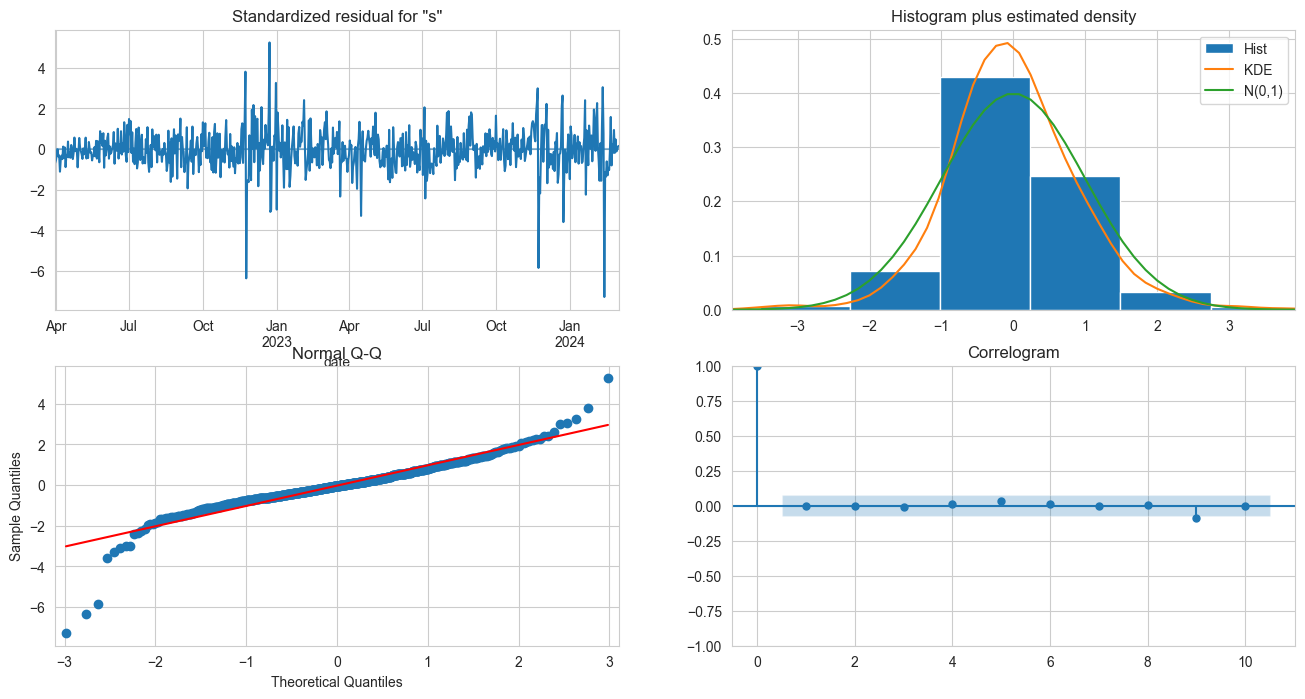

7.757468938827515  OneStepAheadForecast has finished
The Mean Squared Error of our one-step ahead forecasts is 5044797.82


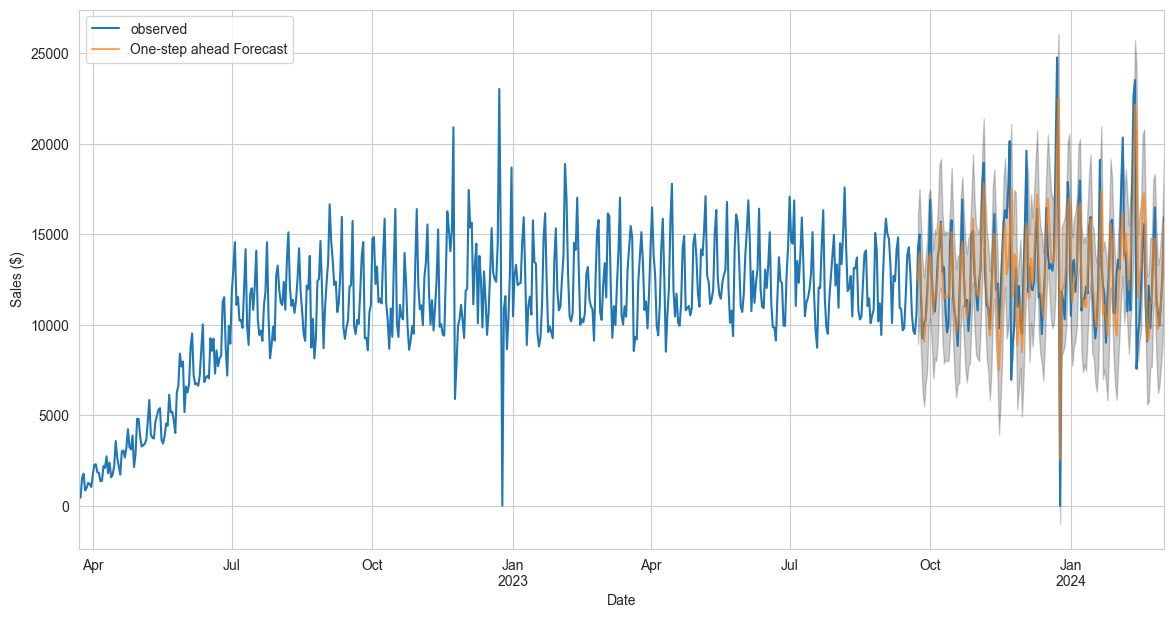

MSE: 5,044,797.82
RMSE: 2,246.06
MAE: 1,487.11
MAPE: 537.88%
R^2: 0.50
The Mean Absolute Percentage Error of our one-step ahead forecasts is 537.88%
The model took 8.00 seconds to run
{'coefficient': -1349.431719624047, 'standard_error': 3914.708632735923, 'confidence_interval': array([-9022.11964975,  6323.25621051])}


/Users/dharmickmehta/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [222]:
def sarima_eva(y,exog, order, seasonal_order, seasonal_period, pred_date, y_to_test,exog_to_test):
    # fit the model
    mod = sm.tsa.statespace.SARIMAX(endog=y,
                                    exog=exog,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_invertibility=False
                                      )
    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # One-step ahead forecast
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False,exog=exog_to_test)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    end_time1 = time.time()
    duration1 = end_time1 - start_time
    print(duration1,' OneStepAheadForecast has finished')
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    
    print('The Mean Squared Error of our one-step ahead forecasts is {}'.format(round(mse, 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales ($)')
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(y_to_test, y_forecasted)

    # Calculate RMSE
    rmse = mean_squared_error(y_to_test, y_forecasted, squared=False)

    # Calculate MAE
    mae = mean_absolute_error(y_to_test, y_forecasted)

    # Calculate MAPE - Handling division by zero if y contains zeros
    mape = np.mean(np.abs((y_to_test - y_forecasted) / y_to_test)) * 100# if np.all(y) else float('inf')
    y_to_test.to_clipboard()
    # Calculate R^2
    r2 = r2_score(y_to_test, y_forecasted)
    print('MSE: {:,.2f}'.format(mse))
    print('RMSE: {:,.2f}'.format(rmse))
    print('MAE: {:,.2f}'.format(mae))
    print('MAPE: {:.2f}%'.format(mape))  # Percentage values don't typically include commas
    print('R^2: {:.2f}'.format(r2))

    # Calculate MAPE for one-step ahead
    mape_one_step = np.mean(np.abs(y_forecasted - y_to_test) / y_to_test) * 100
    print('The Mean Absolute Percentage Error of our one-step ahead forecasts is {:.2f}%'.format(mape_one_step))

    # Dynamic forecast
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True,exog=exog_to_test)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    #print('The Mean Squared Error of our dynamic forecasts is {}'.format(round(mse_dynamic, 2)))

#     ax = y.plot(label='observed')
#     y_forecasted_dynamic.plot(ax=ax, label='Dynamic Forecast', alpha=.7, figsize=(14, 7))
#     ax.fill_between(pred_dynamic_ci.index,
#                     pred_dynamic_ci.iloc[:, 0],
#                     pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Sales ($)')
#     plt.legend()
#    # plt.show()

    # Calculate MAPE for dynamic
#     mse = mean_squared_error(y_to_test, y_forecasted_dynamic)

#     # Calculate RMSE
#     rmse = mean_squared_error(y_to_test, y_forecasted_dynamic, squared=False)

#     # Calculate MAE
#     mae = mean_absolute_error(y_to_test, y_forecasted_dynamic)

#     # Calculate MAPE - Handling  by zero if y contains zeros
#     mape = np.mean(np.abs((y_to_test - y_forecasted_dynamic) / y_to_test)) * 100 if np.all(y) else float('inf')

#     # Calculate R^2
#     r2 = r2_score(y_to_test, y_forecasted_dynamic)
#     print('MSE: {:,.2f}'.format(mse))
#     print('RMSE: {:,.2f}'.format(rmse))
#     print('MAE: {:,.2f}'.format(mae))
#     print('MAPE: {:.2f}%'.format(mape))  # Percentage values don't typically include commas
#     print('R^2: {:.2f}'.format(r2))
    df_forecasts = pd.DataFrame({'Actual Sales': y_to_test,
                                 'One-step Ahead Forecast': y_forecasted,
                                 'Dynamic Forecast': y_forecasted_dynamic})
    df_forecasts.index = y_to_test.index  # Assuming y_to_test is a Series with a DateTimeIndex
    coeff_details = {}
    # Check if the variable is in the model parameters
    variable_name='campaign'
    if variable_name in results.params.index:
        coeff_details['coefficient'] = results.params[variable_name]
        coeff_details['standard_error'] = results.bse[variable_name]
        coeff_details['confidence_interval'] = results.conf_int().loc[variable_name].values
    else:
        print(f"Variable '{variable_name}' not found in the model.")
    model_summary = pd.DataFrame(results.summary().tables[1])
    new_header = model_summary.iloc[0] #grab the first row for the header
    model_summary= model_summary[1:] #take the data less the header row
    model_summary.columns = new_header 
    
    

    return results, df_forecasts,coeff_details,model_summary

# Assume y is defined and y_to_val contains the actual values to validate against
#model = sarima_eva(y, (0, 0, 0), (0, 1, 1, 52), 52, '2023-05-07', y_to_val)

#SARIMA(0, 1, 1)x(1, 1, 1, 52)
start_time = time.time()
#print(y.to_string())
model, df_forecasts, campaign_coeff_details, model_summary  = sarima_eva(y,exog, (1, 1, 1), (1, 1, 1, 7), 7, '2023-09-23', y_to_val,exog_to_val)
end_time = time.time()
duration = end_time - start_time
print(f'The model took {duration:.2f} seconds to run')
# print(len(exog_to_val))
# print(y.index.max())
# print(y.index.min())
# print(exog.index.max())
# print(exog.index.min())
#model, df_forecasts = sarima_eva(y, (0, 1, 1), (1, 1, 1, 365), 365, '2023-05-07', y_to_val)
print(campaign_coeff_details)


In [223]:
print(y.index)
print(exog.index)

DatetimeIndex(['2022-03-23', '2022-03-24', '2022-03-25', '2022-03-26',
               '2022-03-27', '2022-03-28', '2022-03-29', '2022-03-30',
               '2022-03-31', '2022-04-01',
               ...
               '2024-02-22', '2024-02-23', '2024-02-24', '2024-02-25',
               '2024-02-26', '2024-02-27', '2024-02-28', '2024-02-29',
               '2024-03-01', '2024-03-02'],
              dtype='datetime64[ns]', name='date', length=711, freq='D')
DatetimeIndex(['2022-03-23', '2022-03-24', '2022-03-25', '2022-03-26',
               '2022-03-27', '2022-03-28', '2022-03-29', '2022-03-30',
               '2022-03-31', '2022-04-01',
               ...
               '2024-02-22', '2024-02-23', '2024-02-24', '2024-02-25',
               '2024-02-26', '2024-02-27', '2024-02-28', '2024-02-29',
               '2024-03-01', '2024-03-02'],
              dtype='datetime64[ns]', name='date', length=711, freq='D')


In [224]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    
    return (final_table)
#final_table = forecast(model,52,y)
#final_table.head()


In [225]:
print(df_forecasts)
df_forecasts.to_csv('forecast_daily_with_exog2_fourier.csv')

             Actual Sales  One-step Ahead Forecast  Dynamic Forecast
date                                                                
2023-09-23 14249.63000000           12489.16011636    12489.16011636
2023-09-24 14984.46000000           13952.50548532    12972.66460122
2023-09-25 11466.16000000           11903.12317671    10677.40139460
2023-09-26  9251.59000000            9879.52031350     9227.77717730
2023-09-27 10053.73000000            9058.66729073     8814.07239689
...                   ...                      ...               ...
2024-02-27 10632.36000000            9771.08863786     3861.70383889
2024-02-28  9949.90000000           10167.55910784     3215.33216591
2024-02-29 11245.74000000           11279.31584072     5496.71060213
2024-03-01 12758.04000000           12527.09709354     6338.44987562
2024-03-02 15938.70000000           15655.46144760     8287.98755621

[162 rows x 3 columns]


In [226]:
#Calculating camapign incrementality for 2023
# coeff_details['coefficient'] = results.params[variable_name]
# coeff_details['standard_error'] = results.bse[variable_name]
# coeff_details['confidence_interval'] = results.conf_int().loc[variable_name].values

incremental_revenue= campaign_coeff_details['coefficient']*exog.loc['2023-01-01':'2023-12-31', 'campaign'].sum()
incremental_revenue_lower_bound= campaign_coeff_details['confidence_interval'][0]*exog.loc['2023-01-01':'2023-12-31', 'campaign'].sum()
incremental_revenue_upper_bound= campaign_coeff_details['confidence_interval'][1]*exog.loc['2023-01-01':'2023-12-31', 'campaign'].sum()
print(incremental_revenue_lower_bound)
sales_2023=data.loc['2023-01-01':'2023-12-31', 'sales'].sum()
bl_customers_sales=233664921 #this is from Ryan, The total BL customer sales when redeeming rewards


incremental_revenue_over_total_sales = (incremental_revenue/sales_2023)*100
incremental_revenue_lower_bound_over_total_sales = (incremental_revenue_lower_bound/sales_2023)*100
incremental_revenue_upper_bound_over_total_sales = (incremental_revenue_upper_bound/sales_2023)*100

incremental_revenue_over_bl_Customers=(incremental_revenue/bl_customers_sales)*100
incremental_revenue_lower_bound_over_bl_Customers = (incremental_revenue_lower_bound/bl_customers_sales)*100
incremental_revenue_upper_bound_over_bl_Customers = (incremental_revenue_upper_bound/bl_customers_sales)*100

print(f'Incremental Revenue in 2023: $ {incremental_revenue:,.0f}')
print(f'Actual Sales in 2023: $ {sales_2023:,.0f}')
print(f'Incremental Revenue as a percentage: {incremental_revenue_over_total_sales:,.2f} %')
print(f'Incremental Revenue as a percentage of BL Customer Sales: {incremental_revenue_over_bl_Customers:,.2f} %') #This is a stretch
# print(campaign_coeff_details)
# print(campaign_coeff_details['confidence_interval'][0])

print('\n')
print('Lower Bound')
print(f'Incremental Revenue in 2023: $ {incremental_revenue_lower_bound:,.0f}')
print(f'Actual Sales in 2023: $ {sales_2023:,.0f}')
print(f'Incremental Revenue as a percentage: {incremental_revenue_lower_bound_over_total_sales:,.2f} %')
print(f'Incremental Revenue as a percentage of BL Customer Sales: {incremental_revenue_lower_bound_over_bl_Customers:,.2f} %') #This is a stretch
print('\n')

print('Upper Bound')
print(f'Incremental Revenue in 2023: $ {incremental_revenue_upper_bound:,.0f}')
print(f'Actual Sales in 2023: $ {sales_2023:,.0f}')
print(f'Incremental Revenue as a percentage: {incremental_revenue_upper_bound_over_total_sales:,.2f} %')
print(f'Incremental Revenue as a percentage of BL Customer Sales: {incremental_revenue_upper_bound_over_bl_Customers:,.2f} %') #This is a stretch


print('\n')

# Save model output in a file for posterity
print(model_summary)
sales_2022=data.loc['2022-01-01':'2022-12-31', 'sales'].sum()
sales_2021=data.loc['2021-01-01':'2021-12-31', 'sales'].sum()
print(f'Actual Sales in 2021: $ {sales_2021:,.0f}')
print(f'Actual Sales in 2022: $ {sales_2022:,.0f}')
output_file_path = f'SarimaxFourier/model_output_{K}.xlsx'
with pd.ExcelWriter(output_file_path) as writer:
    # Write the summary to the 'model_summary' sheet
    # Convert the summary to a string, then write to Excel
    summary_str = model.summary().as_text()
    summary_lines = summary_str.split('\n')
    summary_data = [line.split() for line in summary_lines]
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, index=False, header=False, sheet_name='model_summary')

    # Write the 'df' DataFrame to the 'df data' sheet
    df.to_excel(writer, sheet_name='df data')

print(summary_str)

# Save the workbook
writer.save()
sales_2022=data.loc['2022-01-01':'2022-12-31', 'sales'].sum()
sales_2021=data.loc['2021-01-01':'2021-12-31', 'sales'].sum()
print(sales_2021)
print(sales_2022)

-3293073.6721603903
Incremental Revenue in 2023: $ -492,543
Actual Sales in 2023: $ 4,596,043
Incremental Revenue as a percentage: -10.72 %
Incremental Revenue as a percentage of BL Customer Sales: -0.21 %


Lower Bound
Incremental Revenue in 2023: $ -3,293,074
Actual Sales in 2023: $ 4,596,043
Incremental Revenue as a percentage: -71.65 %
Incremental Revenue as a percentage of BL Customer Sales: -1.41 %


Upper Bound
Incremental Revenue in 2023: $ 2,307,989
Actual Sales in 2023: $ 4,596,043
Incremental Revenue as a percentage: 50.22 %
Incremental Revenue as a percentage of BL Customer Sales: 0.99 %


0                         coef    std err          z   P>|z|     [0.025  \
1              day     -6.9845   1773.247     -0.004   0.997  -3482.486   
2   public_holiday  -1.066e+04    689.601    -15.457   0.000   -1.2e+04   
3         campaign  -1349.4317   3914.709     -0.345   0.730  -9022.120   
4       campaign_1  -2770.9633   1730.030     -1.602   0.109  -6161.760   
5       campaign

OSError: Cannot save file into a non-existent directory: 'SarimaxFourier'

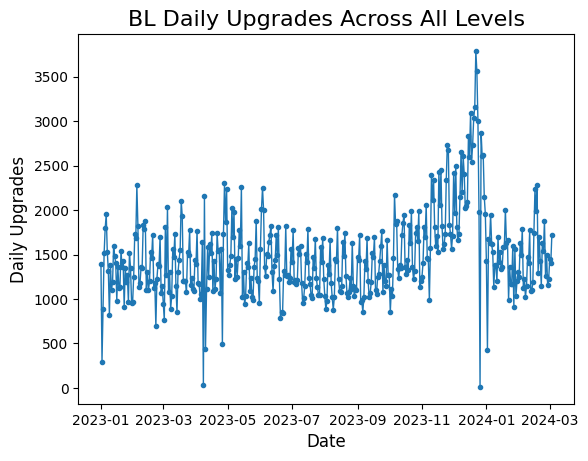

<Figure size 2000x100100 with 0 Axes>

['2023-01-01', '2023-10-03']
['2023-10-04', '2023-10-18']


C:\Users\dharmickmehta\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


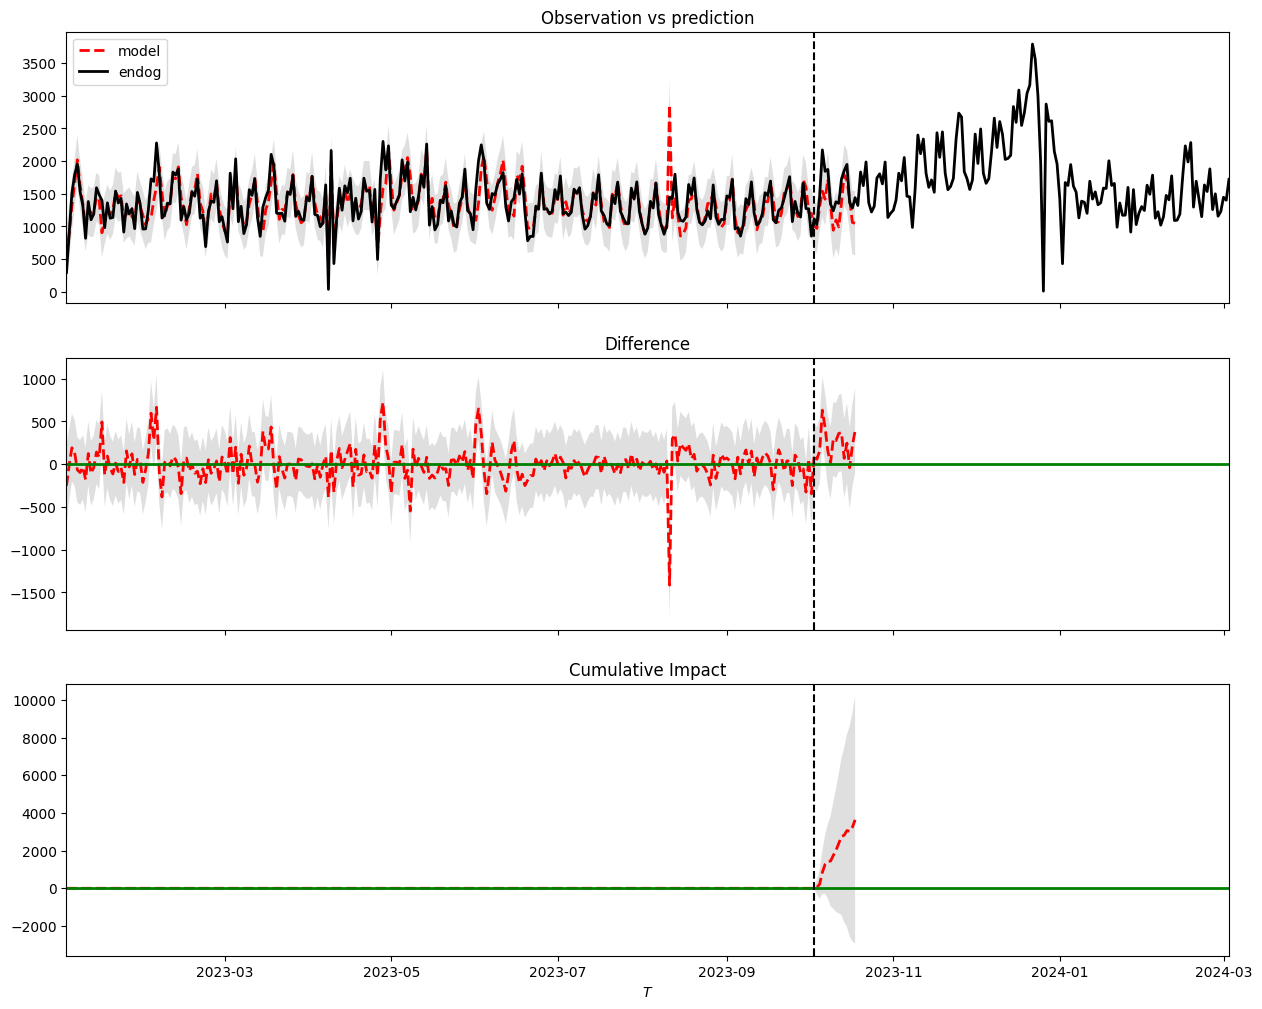

                                Average       Cumulative
Actual                             1553            23300
Predicted                          1311            19668
95% CI                      [874, 1748]   [13114, 26223]
                                                        
Absolute Effect                     242             3631
95% CI                      [679, -194]   [10185, -2923]
                                                        
Relative Effect                   18.5%            18.5%
95% CI                  [51.8%, -14.9%]  [51.8%, -14.9%]
                                                        
P-value                            0.0%                 
Prob. of Causal Effect           100.0%                 


In [ ]:
from causalimpact import CausalImpact
import pandas as pd
import matplotlib.pyplot as plt


# Assuming you have a DataFrame `df` with a DateTime index and a 'sales' column
# Here's how you might construct such a DataFrame for demonstration:
#df = pd.DataFrame({'sales': [your_sales_data_here]}, index=pd.date_range(start="2023-01-01", periods=your_data_length))
df=pd.read_csv(r'C:\Users\dharmickmehta\OneDrive - COSMETICS CUBED PTY LTD\Tiering2023.csv')
# Define the period before and after the event


# Since we don't have the actual file, we will simulate reading your Excel data.
# You can replace this part with `df = pd.read_excel('path_to_your_file.xlsx')`
# to load your data directly from the Excel file.
# data = {
#     'start_date': ['8/06/2023', '10/06/2023', '24/09/2023', '15/02/2023'],
#     'upgrades': [1479, 1722, 1761, 1743],
#     'maintain': [634, 955, 1156, 4165],
#     'downgrades': [1348, 1911, 2254, 3078]
# }

# df = pd.DataFrame(data)
df['start_date'] = pd.to_datetime(df['start_date'], format='%d/%m/%Y')
df.set_index('start_date', inplace=True)
df.sort_index(inplace=True)

fig, ax = plt.subplots()  # Create a figure containing a single axes.
plt.plot(df.index,df['upgrades'],marker='.', linestyle='-', linewidth=1, label='Upgrades')
#ax.plot(df.index,df['maintain'], linestyle='-', linewidth=3, label='Maintain')
# Sort the DataFrame by the index to ensure the time series is in correct order
plt.title('BL Daily Upgrades Across All Levels',fontsize=16)
plt.ylabel('Daily Upgrades',fontsize=12)
plt.xlabel('Date',fontsize=12)
plt.figure(figsize=(20,1001))
plt.show()

plt.show()

# Assume the event date is October 4th, 2023
# If the actual event date is different, update this accordingly.
event_date = '2023-10-04'

# Define the pre-intervention and post-intervention periods
# The pre_period and post_period should be in the format (start_date, end_date)
#                 Using the whole dataset
# pre_period = [df.index.min().strftime('%Y-%m-%d'), (pd.to_datetime(event_date) - pd.Timedelta(days=1)).strftime('%Y-%m-%d')]
# post_period = [event_date, df.index.max().strftime('%Y-%m-%d')]
#                 Using whole pre-period and 2 weeks after
pre_period = [df.index.min().strftime('%Y-%m-%d'), (pd.to_datetime(event_date) - pd.Timedelta(days=1)).strftime('%Y-%m-%d')]
post_period = [event_date, (pd.to_datetime(event_date) + pd.Timedelta(weeks=2)).strftime('%Y-%m-%d')]
# pre_period = [(pd.to_datetime(event_date) - pd.Timedelta(weeks=2)).strftime('%Y-%m-%d'), 
#               (pd.to_datetime(event_date) - pd.Timedelta(days=1)).strftime('%Y-%m-%d')]
# post_period = [(pd.to_datetime(event_date) + pd.Timedelta(days=0)).strftime('%Y-%m-%d'), 
#                (pd.to_datetime(event_date) + pd.Timedelta(weeks=2)).strftime('%Y-%m-%d')]

print(pre_period)
print(post_period)
# Run the CausalImpact analysis on the 'upgrades' column
ci = CausalImpact(df, pre_period, post_period)
ci.run()
ci.plot()
ci.summary()